In [ ]:
from astropy.io import fits
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from reproject import reproject_interp
from matplotlib import pyplot as plt
from glob import glob 
from tqdm.auto import tqdm
import warnings 
from astropy.table import Table, join
import pickle
from matplotlib.ticker import (AutoMinorLocator)
from astropy.modeling import models, fitting
import sys
import warnings 
sys.path.append('./../')
warnings.filterwarnings('ignore')

from tools_contsub_misc import *
from tools_contsub_anchoring import * 
from tools_contsub_plots import *

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [ ]:
def save_pickle(a, filename):
    """
    Save an object to a pickle file.
    """
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('[INFO] [save_pickle] Saved to %s' %filename)

def load_pickle(filename):
    """
    Load an object from a pickle file.
    """
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    print('[INFO] [load_pickle] Load %s' %filename)
    return b

def get_hdu(rootdir, filename, hdu_id=0):
    filename_full = glob(rootdir+filename)[0]
    print(filename_full)
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    return(hdu)

def get_flux_nebs(hdu1, hdu2, hdu_neb1, hdu_neb2, filter='', make_plots=True):

    data_neb = hdu_neb1.data.copy()
    ids1 = np.unique(data_neb)
    ids1.sort()
    ids1 = list(ids1)
    ids1.remove(-1)

    data_neb = hdu_neb2.data.copy()
    ids2 = np.unique(data_neb)
    ids2.sort()
    ids2 = list(ids2)
    ids2.remove(-1)

    ids = []
    for id in tqdm(np.unique(np.hstack([ids1, ids2]))):
        if (id in ids1) &  (id in ids2): 
            ids += [id]

    flux_1 = np.ones(len(ids))
    flux_2 = np.ones(len(ids))
    
    for i in tqdm(range(len(ids))): 

        id = ids[i]

        mask1 = hdu_neb1.data == id
        mask2 = hdu_neb2.data == id

        flux_1[i] = np.nansum(hdu1.data[mask1])
        flux_2[i] = np.nansum(hdu2.data[mask2])
        
    return(flux_1, flux_2, ids)

def get_museprops(galaxy, muscat_file):
    """
    Get properties from MUSE catalouge
    """

    print(f'[INFO] [get_MuseProps] Getting MUSE catalouge properties for {galaxy}...')
    muscat_table = Table.read(muscat_file)
    muscat_table = muscat_table[muscat_table['gal_name'] == galaxy.swapcase()]
    return(muscat_table)


In [78]:
galaxies = [
            'ic5332',
            'ngc628e',
            'ngc628c',  
            'ngc1087',          
            'ngc1300',
            'ngc1365n',
            'ngc1385',
            'ngc1433',
            'ngc1566',
            'ngc1672',
            'ngc2835s',
            'ngc3351',
            'ngc3627',
            'ngc4254',
            'ngc4321',
            'ngc5068',
            'ngc7496',
            ]

galaxies_muse = [
            'ic5332',
            'ngc0628',
            'ngc0628',  
            'ngc1087',          
            'ngc1300',
            'ngc1365',
            'ngc1385',
            'ngc1433',
            'ngc1566',
            'ngc1672',
            'ngc2835',
            'ngc3351',
            'ngc3627',
            'ngc4254',
            'ngc4321',
            'ngc5068',
            'ngc7496',
            ]

# galaxies = ['ngc628c']
# galaxies_muse = ['ngc0628']

root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
muscat_table_file = '%s/data_misc/nebulae_catalogue/Nebulae_catalogue_v3.fits' %root_dir

In [79]:
muscat_table_joined_all = {}
run = False 

if run: 
    for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

        # Load files for galaxy
        print (galaxy, galaxy_muse)
        rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
        hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
        hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')
        hdu_muse_ha     = hdu_muse['HA6562_FLUX']
        hdu_hst_ha_crop = get_hdu(rootdir, 'hst_contsub/%s_hst_ha.fits' %galaxy)

        # Load MUSE properties
        muscat_table = get_museprops(galaxy_muse, muscat_table_file)

        # Reproject MUSE mask to HST grid
        data_output = reproject_interp(hdu_muse_neb, hdu_hst_ha_crop.header, order='nearest-neighbor')[0]
        hdu_muse_neb_re = fits.PrimaryHDU(data_output, hdu_hst_ha_crop.header)

        # Extract fluxes from MUSE and HST 
        flux_1, flux_2, ids = get_flux_nebs(hdu_muse_ha, hdu_hst_ha_crop, hdu_muse_neb, hdu_muse_neb_re)

        # Make MUSE catalouge table
        unit = muscat_table['HA6562_FLUX'].unit
        data = [ids, flux_1*unit, flux_2*unit, (flux_2*unit)/(flux_1*unit)]
        names = ['region_ID', 'flux_muse', 'flux_hst', 'flux_hst/muse']
        table_neb = Table(data=data, names=names)
        muscat_table_joined = join(table_neb, muscat_table, keys='region_ID')

        muscat_table_joined_all[galaxy] = muscat_table_joined

    save_pickle(muscat_table_joined_all, './muscat_table_joined_all.pkl')
else:
    muscat_table_joined_all = load_pickle('./muscat_table_joined_all.pkl')

ic5332 ic5332
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/muse/IC5332-0.87asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ic5332/hst_contsub/ic5332_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ic5332...


  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/816 [00:00<?, ?it/s]

ngc628e ngc0628
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628e/muse/NGC0628_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628e/muse/NGC0628-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628e/hst_contsub/ngc628e_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc0628...


  0%|          | 0/2870 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

ngc628c ngc0628
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub/ngc628c_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc0628...


  0%|          | 0/2870 [00:00<?, ?it/s]

  0%|          | 0/2785 [00:00<?, ?it/s]

ngc1087 ngc1087
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1087/muse/NGC1087_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1087/muse/NGC1087-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1087/hst_contsub/ngc1087_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1087...


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/1011 [00:00<?, ?it/s]

ngc1300 ngc1300
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1300/muse/NGC1300_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1300/muse/NGC1300-0.89asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1300/hst_contsub/ngc1300_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1300...


  0%|          | 0/1479 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

ngc1365n ngc1365
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/muse/NGC1365_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/muse/NGC1365-1.15asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/hst_contsub/ngc1365n_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1365...


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/1241 [00:00<?, ?it/s]

ngc1385 ngc1385
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1385/muse/NGC1385_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1385/muse/NGC1385-0.77asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1385/hst_contsub/ngc1385_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1385...


  0%|          | 0/1030 [00:00<?, ?it/s]

  0%|          | 0/1029 [00:00<?, ?it/s]

ngc1433 ngc1433
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/muse/NGC1433_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/muse/NGC1433-0.91asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/hst_contsub/ngc1433_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1433...


  0%|          | 0/1737 [00:00<?, ?it/s]

  0%|          | 0/1577 [00:00<?, ?it/s]

ngc1566 ngc1566
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1566/muse/NGC1566_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1566/muse/NGC1566-0.80asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1566/hst_contsub/ngc1566_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1566...


  0%|          | 0/2405 [00:00<?, ?it/s]

  0%|          | 0/2315 [00:00<?, ?it/s]

ngc1672 ngc1672
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1672/muse/NGC1672_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1672/muse/NGC1672-0.96asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1672/hst_contsub/ngc1672_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc1672...


  0%|          | 0/1582 [00:00<?, ?it/s]

  0%|          | 0/1581 [00:00<?, ?it/s]

ngc2835s ngc2835
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc2835s/muse/NGC2835_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc2835s/muse/NGC2835-1.15asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc2835s/hst_contsub/ngc2835s_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc2835...


  0%|          | 0/1122 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

ngc3351 ngc3351
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3351/muse/NGC3351_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3351/muse/NGC3351-1.05asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3351/hst_contsub/ngc3351_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc3351...


  0%|          | 0/1285 [00:00<?, ?it/s]

  0%|          | 0/1284 [00:00<?, ?it/s]

ngc3627 ngc3627
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/muse/NGC3627_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/muse/NGC3627-1.05asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/hst_contsub/ngc3627_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc3627...


  0%|          | 0/1636 [00:00<?, ?it/s]

  0%|          | 0/1183 [00:00<?, ?it/s]

ngc4254 ngc4254
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/muse/NGC4254_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/muse/NGC4254-0.89asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4254/hst_contsub/ngc4254_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc4254...


  0%|          | 0/2961 [00:00<?, ?it/s]

  0%|          | 0/2960 [00:00<?, ?it/s]

ngc4321 ngc4321
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/muse/NGC4321_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/muse/NGC4321-1.16asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/hst_contsub/ngc4321_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc4321...


  0%|          | 0/1848 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

ngc5068 ngc5068
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/muse/NGC5068_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/muse/NGC5068-1.04asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/hst_contsub/ngc5068_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc5068...


  0%|          | 0/1858 [00:00<?, ?it/s]

  0%|          | 0/1846 [00:00<?, ?it/s]

ngc7496 ngc7496
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc7496/muse/NGC7496_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc7496/muse/NGC7496-0.89asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc7496/hst_contsub/ngc7496_hst_ha.fits
[INFO] [get_MuseProps] Getting MUSE catalouge properties for ngc7496...


  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/777 [00:00<?, ?it/s]

[INFO] [save_pickle] Saved to ./muscat_table_joined_all.pkl


In [80]:
muscat_table_joined_all

{'ic5332': <Table length=816>
 region_ID      flux_muse            flux_hst      ... HII_class_v2 HII_class_v3
           1e-20 erg / (s cm2) 1e-20 erg / (s cm2) ...                          
  float64        float64             float64       ...    int64        int64    
 --------- ------------------- ------------------- ... ------------ ------------
       0.0   884743.0126230643        33548.796875 ...            0            0
       1.0   4170.883874524424     5239.6650390625 ...            0            0
       2.0   12917.71392992572                 0.0 ...            0            0
       3.0   58092.36171807921     11802.162109375 ...            1            0
       4.0  6199.1345206726655           13796.625 ...            1            1
       5.0   5149.159543631676     9504.9970703125 ...            0            0
       6.0  6894.7292882604925      21380.52734375 ...            1            1
       7.0  117477.81334182275          137362.375 ...            1            

In [81]:
bbox = dict(facecolor='whitesmoke',  alpha=0.95, boxstyle='round')

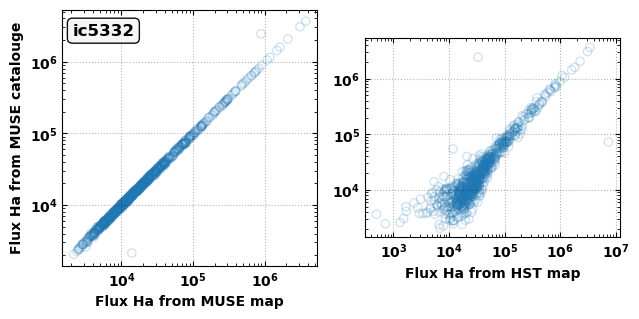

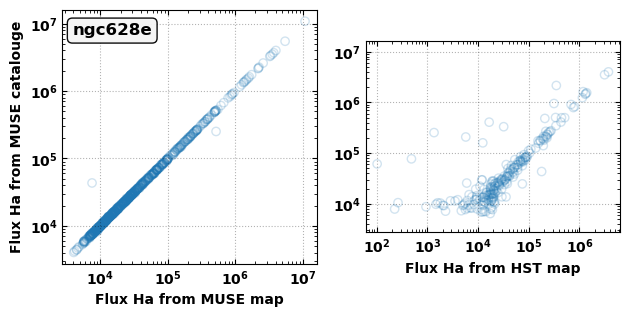

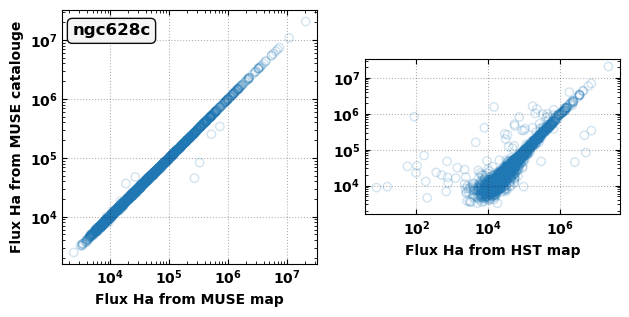

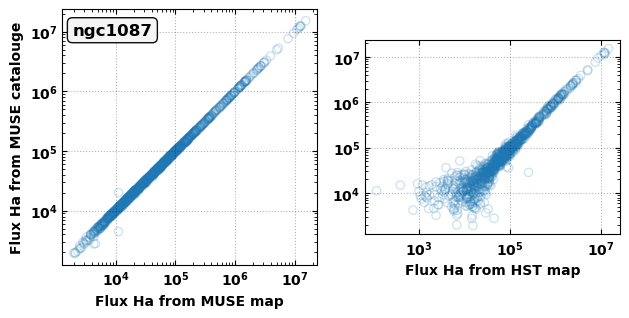

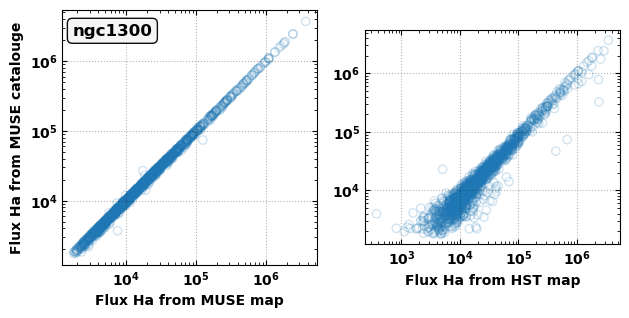

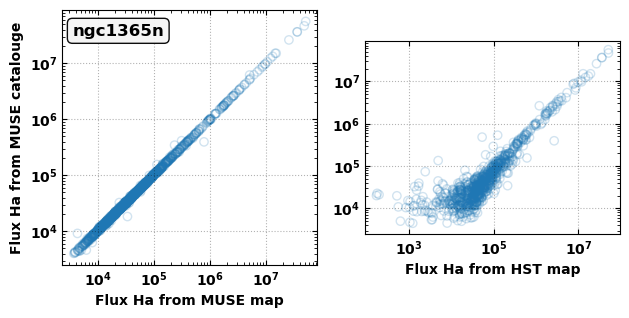

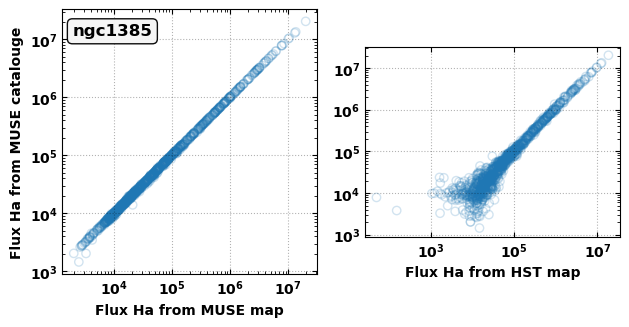

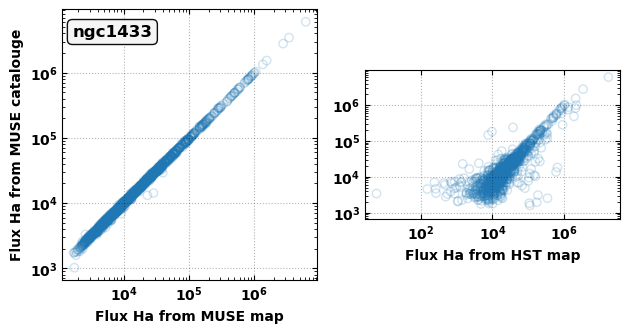

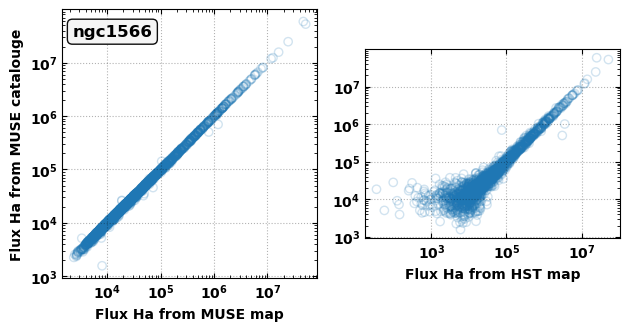

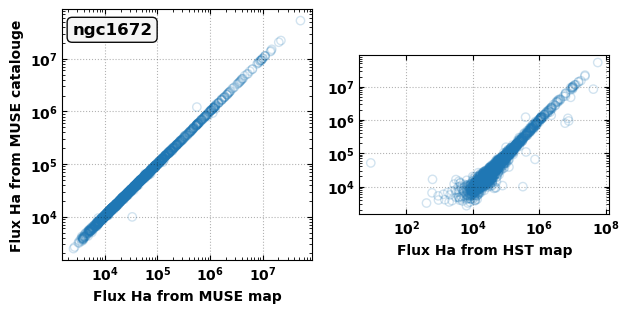

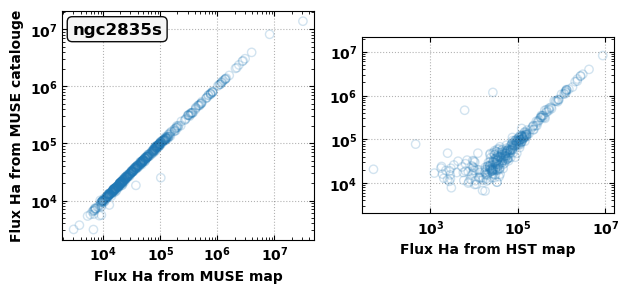

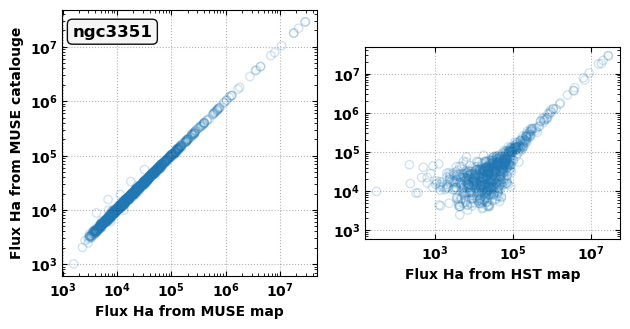

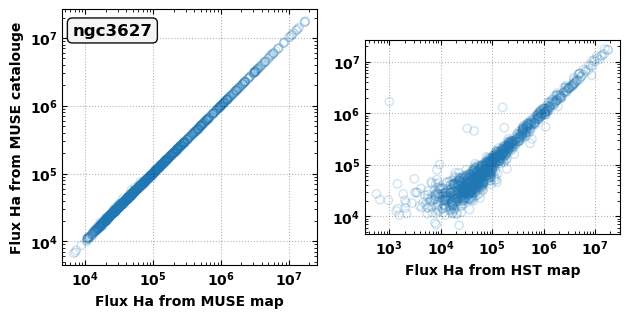

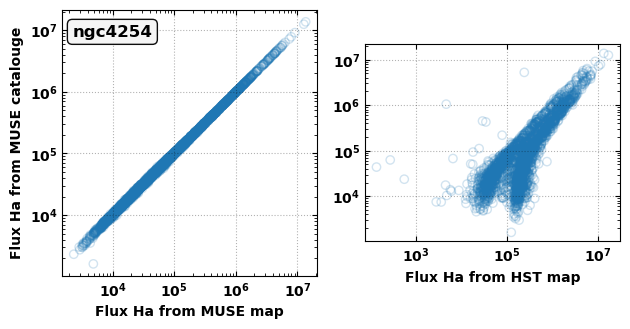

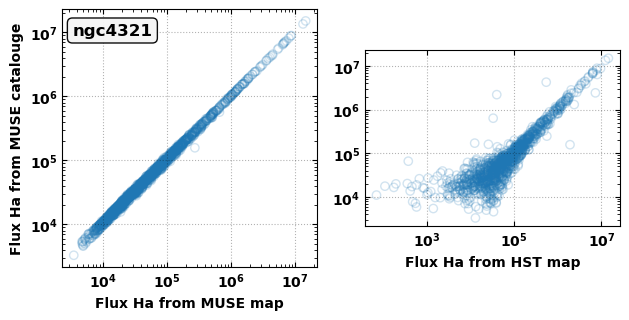

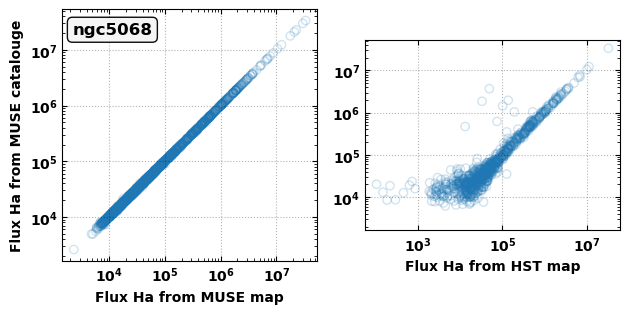

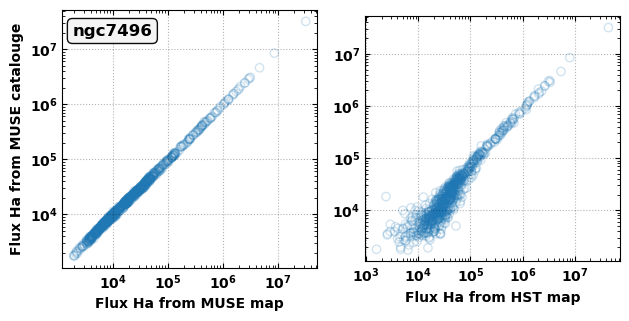

In [82]:
for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)

    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    ax1.scatter(muscat_table_joined_all[galaxy]['flux_muse'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)
    ax2.scatter(muscat_table_joined_all[galaxy]['flux_hst'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)

    ax1.set_xlabel('Flux Ha from MUSE map')
    ax1.set_ylabel('Flux Ha from MUSE catalouge')
    ax2.set_xlabel('Flux Ha from HST map')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax1.text(0.04, 0.9, '%s' %galaxy, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    ax1.grid(True, alpha=0.3, ls=':', color='black')
    ax2.grid(True, alpha=0.3, ls=':', color='black')
    fig.tight_layout()

    fig.savefig('./figs/%s_fluxcomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

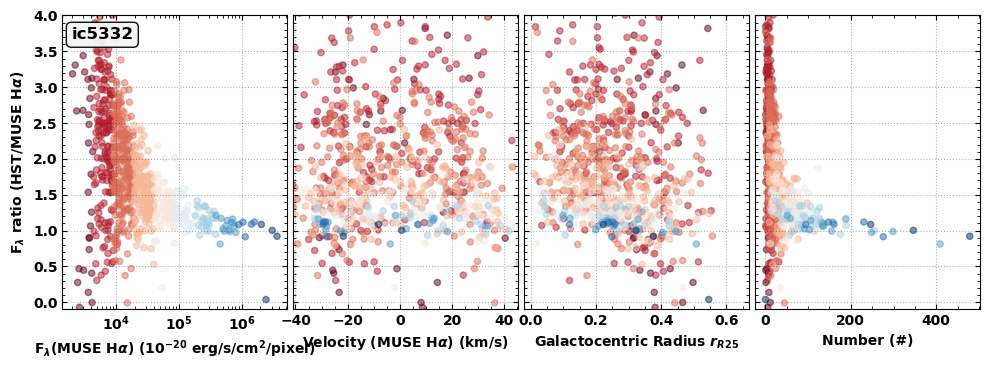

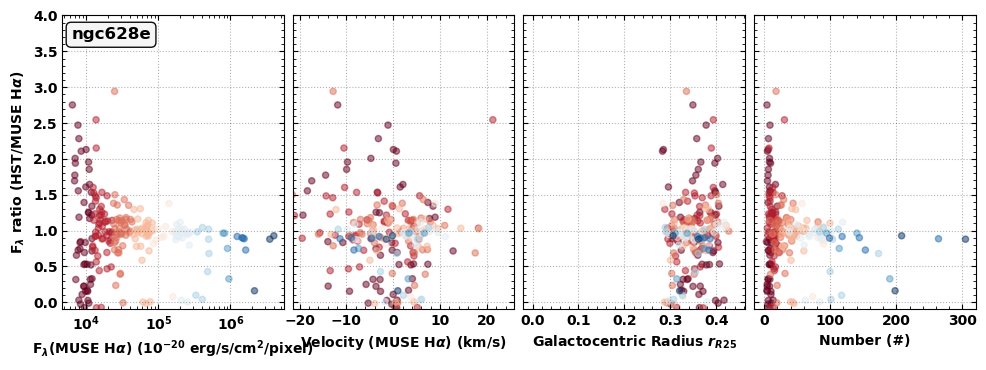

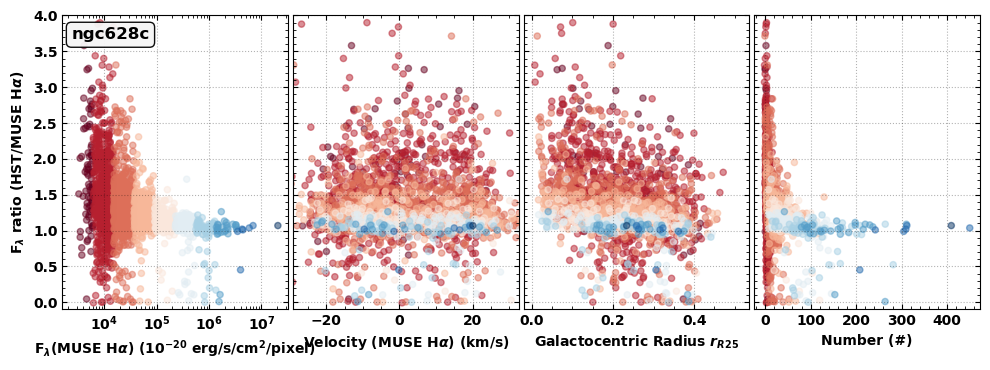

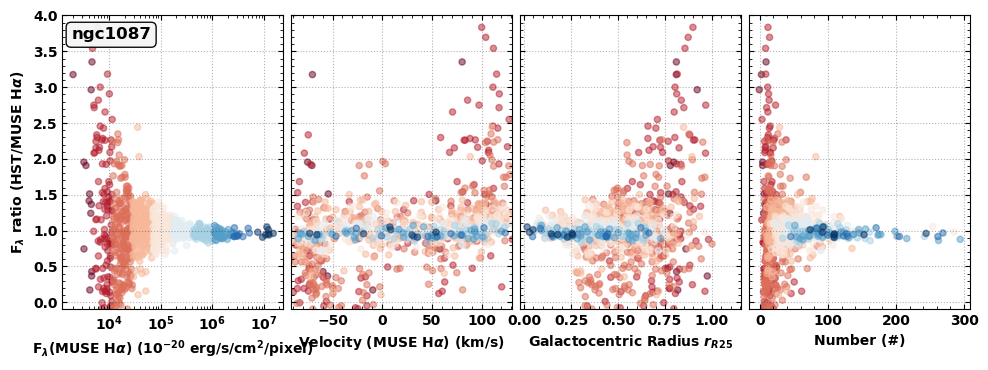

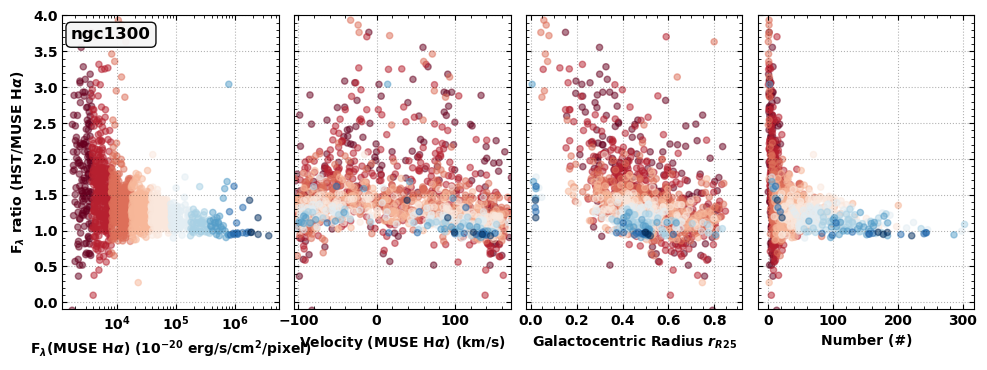

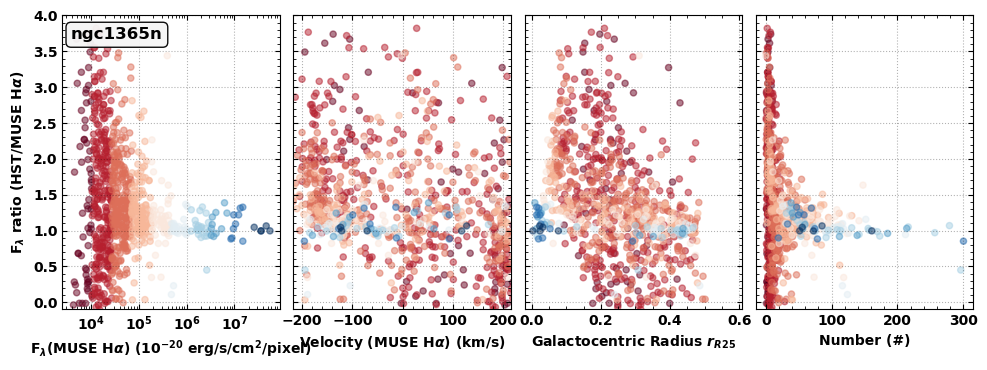

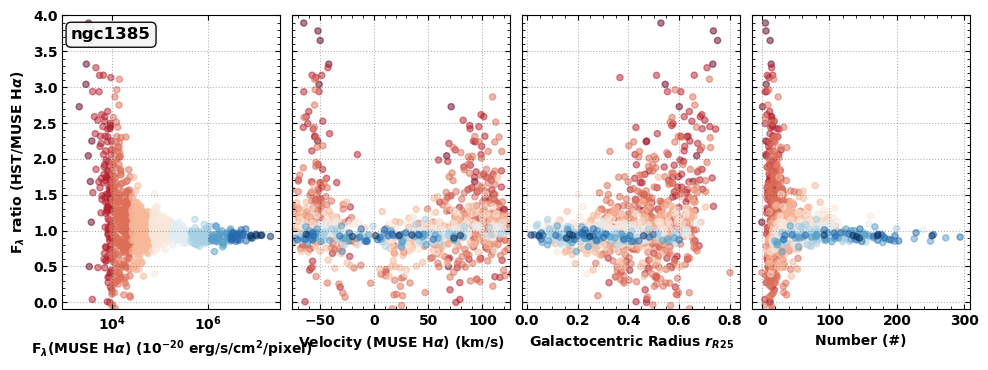

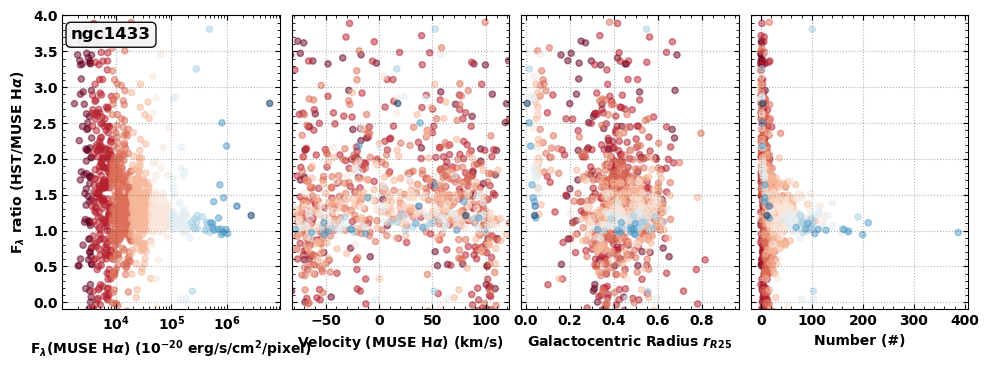

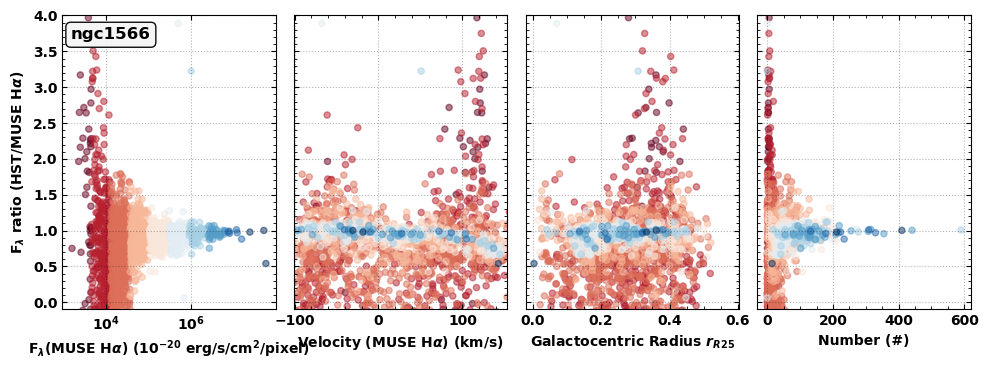

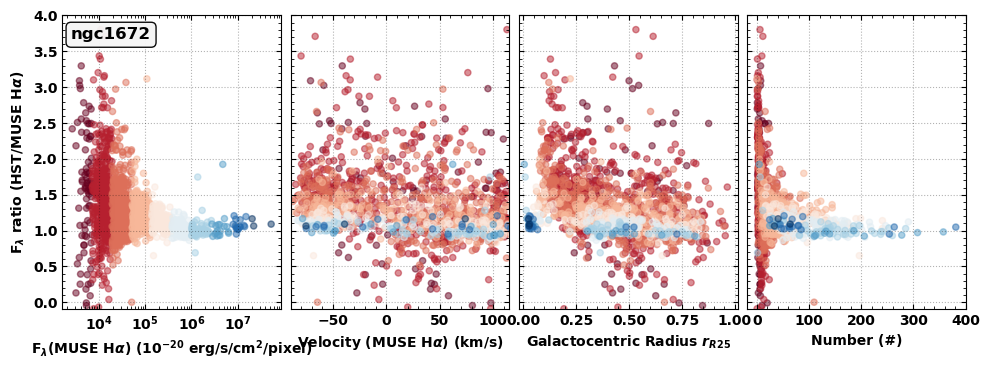

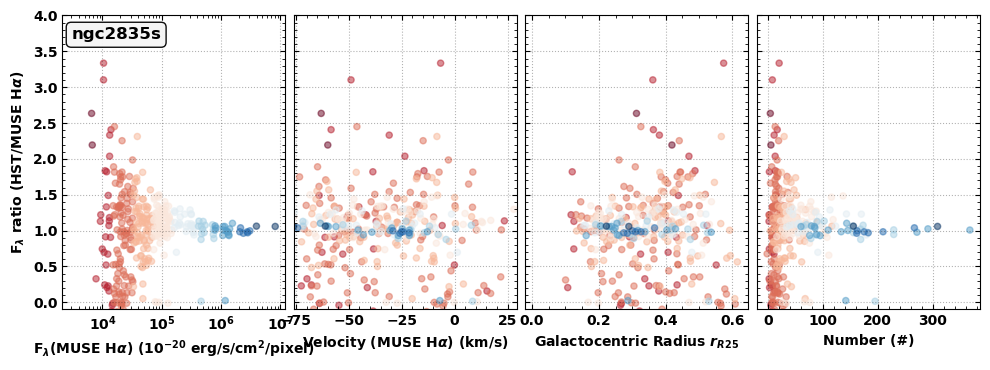

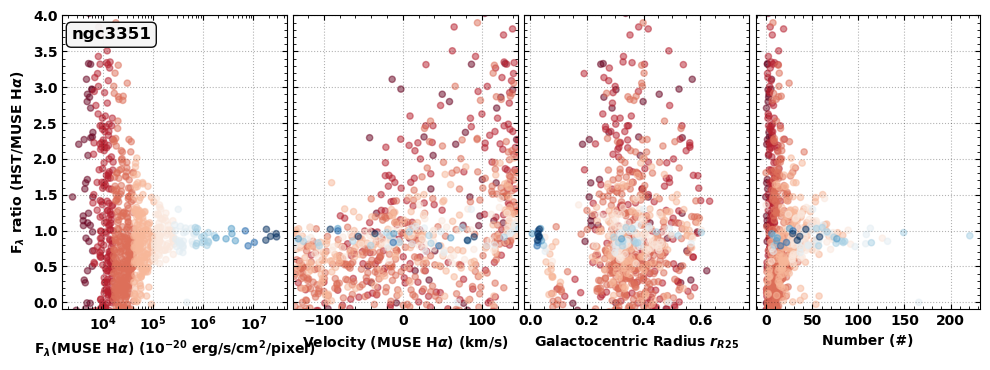

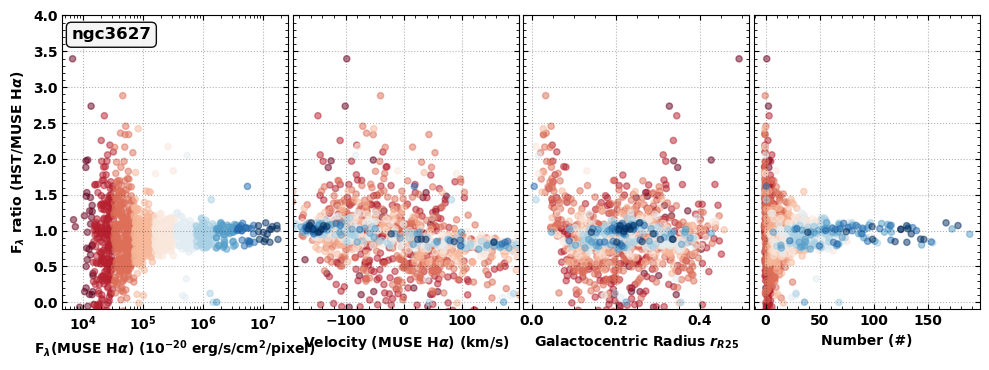

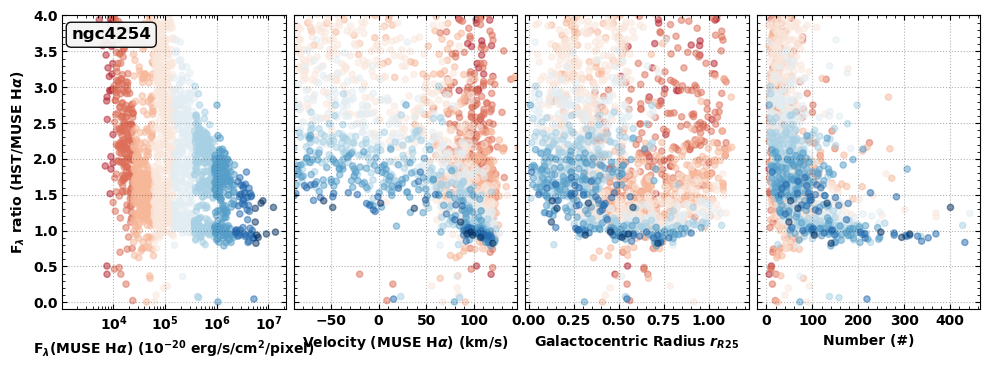

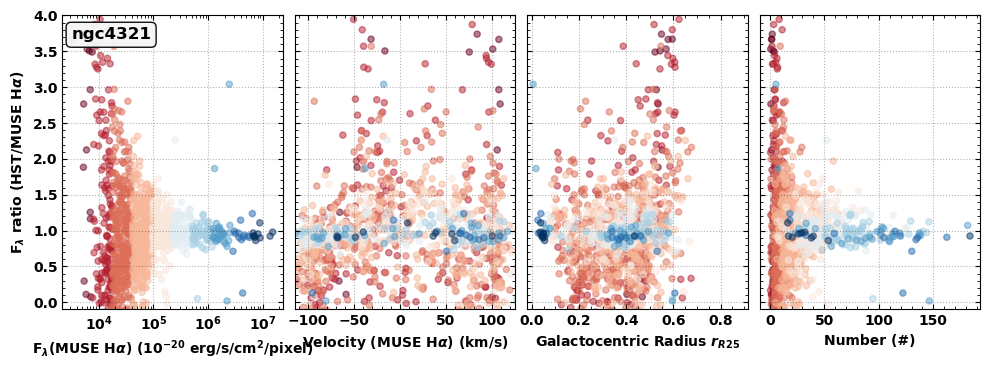

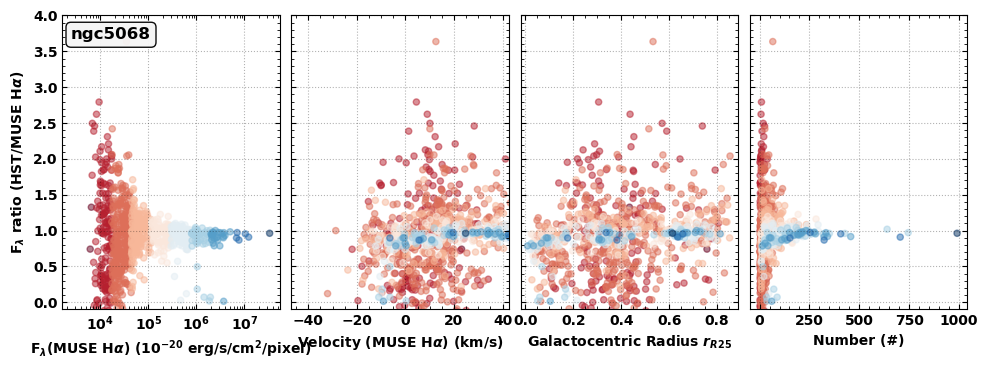

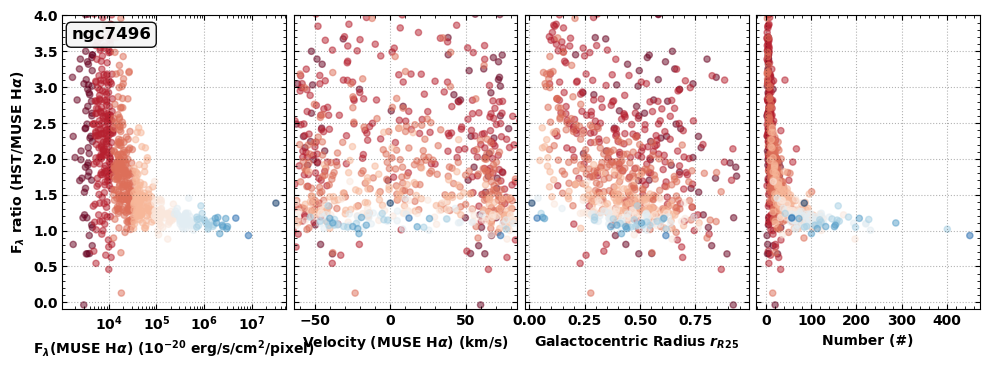

In [83]:
for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    fig = plt.figure(figsize=(10, 3.8))

    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,1]) 

    ax1 = fig.add_subplot(gs[2])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[0]) 
    ax4 = fig.add_subplot(gs[3])

    table = muscat_table_joined_all[galaxy].copy()
    table.sort('HA6562_FLUX')

    ratio = table['flux_hst/muse']
    mask = ratio!=0

    ratio = table['flux_hst/muse'][mask]
    r_R25 = table['r_R25'][mask]
    HA6562_VEL = table['HA6562_VEL'][mask]
    HA6562_FLUX = table['HA6562_FLUX'][mask]
    EW_HA6562_raw = table['EW_HA6562_raw'][mask]

    cdata = HA6562_FLUX
    cdata = np.log10(cdata)
    cmap = plt.get_cmap('RdBu', 10)
    norm = mpl.colors.Normalize(vmin=3, vmax=7)

    ax1.scatter(r_R25, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    ax2.scatter(HA6562_VEL, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    ax3.scatter(HA6562_FLUX, ratio, cmap=cmap, c=cdata, alpha=0.5, s=20)
    ax4.scatter(EW_HA6562_raw, ratio, cmap=cmap, c=cdata, alpha=0.5,  s=20)

    ax3.set_ylabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
    ax1.set_xlabel(r'Galactocentric Radius $r_{R25}$')
    ax2.set_xlabel(r'Velocity (MUSE H$\alpha$) (km/s)')
    ax3.set_xlabel(r'F$_\lambda$(MUSE H$\alpha$) (10$^{-20}$ erg/s/cm$^2$/pixel)')
    ax4.set_xlabel('Number (#)')

    for ax in [ax1,ax2,ax3,ax4]:

        ax.set_ylim(-0.1, 4)
        ax.grid(True, alpha=0.3, ls=':', color='black')

    ax1.set_xlim([-.02, muscat_table_joined_all[galaxy]['r_R25'][mask].max()*1.05])
    ax2.set_xlim(np.nanpercentile(muscat_table_joined_all[galaxy]['HA6562_VEL'][mask], [0.5,99.5]))

    ax3.set_xscale('log')

    ax2.set_yticklabels([])
    ax1.set_yticklabels([])
    ax4.set_yticklabels([])

    for ax in [ax1,ax2,ax4]:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax3.yaxis.set_minor_locator(AutoMinorLocator())

    ax3.text(0.04, 0.96, '%s' %galaxy, transform=ax3.transAxes, bbox=bbox, fontsize=12, va='top')

    plt.tight_layout(h_pad=0, w_pad=-0.1)
    fig.savefig('./figs/%s_ratiocomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

ic5332: 0.63 0.14
ngc628e: 0.19 0.08
ngc628c: 0.24 0.09
ngc1087: 0.16 0.08
ngc1300: 0.24 0.13
ngc1365n: 0.52 0.14
ngc1385: 0.14 0.07
ngc1433: 0.45 0.11
ngc1566: 0.25 0.11
ngc1672: 0.26 0.12
ngc2835s: 0.22 0.11
ngc3351: 0.64 0.15
ngc3627: 0.23 0.15
ngc4254: 0.73 0.71
ngc4321: 0.35 0.13
ngc5068: 0.22 0.10
ngc7496: 0.57 0.10


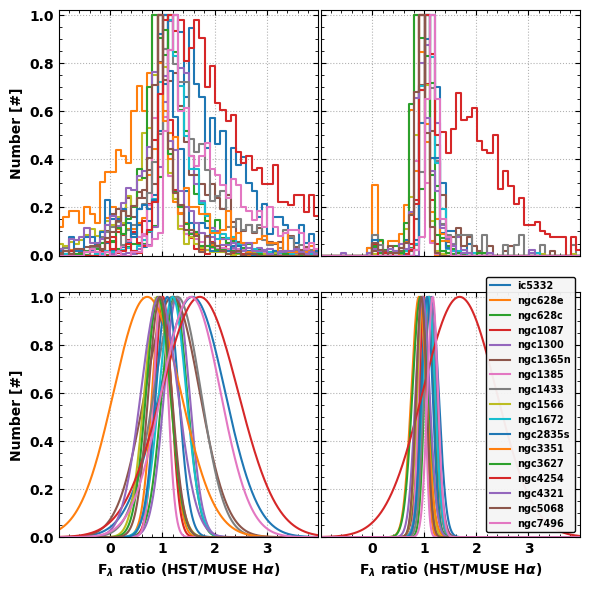

In [84]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio = muscat_table_joined_all[galaxy]['flux_hst/muse']
    mask = ratio!=0
    mask_lum = muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask] > 1e5

    bins = np.arange(-10,10,0.1)
    data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
    data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
    data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
    bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

    data_hist = data_hist/data_hist.max()
    data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()
    
    g = fit_g(g_init, bins_center, data_hist)
    g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
    print('%s: %0.2f %0.2f' %(galaxy,g.stddev.value, g_lmask2.stddev.value))

    ax1.plot(bins_center, data_hist, ds='steps-mid', label='%s' %galaxy)
    # ax1.fill_between(bins_center, data_hist, y2=0, step="mid", alpha=0.2, zorder=0)

    ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label='%s' %galaxy)
    # ax2.fill_between(bins_center, data_hist_lmask2, y2=0, step="mid", alpha=0.2, zorder=0)

    bins = np.arange(-10,10,0.01)
    ax3.plot(bins, g(bins)/g(bins).max(), label='%s' %galaxy)
    ax4.plot(bins, g_lmask2(bins)/g_lmask2(bins).max(), label='%s' %galaxy)

for ax in [ax1, ax2, ax3, ax4]:

    ax.set_xlim(-0.99, 3.99)
    ax.grid(True, alpha=0.3, ls=':', color='black')
    ax.set_ylim([0, 1.02])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

ax4.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=7)

for ax in [ax2, ax4]:
    ax.set_yticklabels([])

for ax in [ax1, ax2]:
    ax.set_xticklabels([])

ax3.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax4.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax1.set_ylabel('Number [#]')
ax3.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.2)
fig.savefig('./figs/all_ratiohist.pdf', bbox_inches='tight', dpi=300)  

0.34 0.14


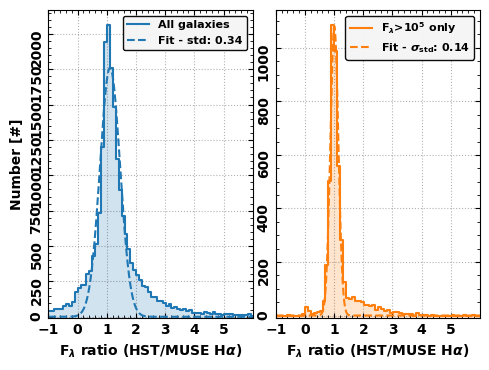

In [85]:
fig = plt.figure(figsize=(5, 3.8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

ratio = []
lum = []

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio += [np.squeeze(muscat_table_joined_all[galaxy]['flux_hst/muse'].quantity.value)]
    lum += [np.squeeze(muscat_table_joined_all[galaxy]['HA6562_FLUX'].quantity.value)]

ratio = np.hstack(ratio)
lum = np.hstack(lum)

mask = ratio!=0
mask_lum = lum[mask] > 1e5

bins = np.arange(-10,10,0.1)
data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

# data_hist = data_hist/data_hist.max()
# data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()

g = fit_g(g_init, bins_center, data_hist)
g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
print('%0.2f %0.2f' %(g.stddev.value, g_lmask2.stddev.value))

ax1.plot(bins_center, data_hist, ds='steps-mid', label='All galaxies')
ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label=r'F$_\lambda$>$10^5$ only', c='C1')

ax1.fill_between(bins_center, data_hist, y2=-100, step="mid", alpha=0.2, zorder=0)
ax2.fill_between(bins_center, data_hist_lmask2, y2=-100, step="mid", alpha=0.2, zorder=0, fc='C1')

bins = np.arange(-10,10,0.01)
ax1.plot(bins, g(bins), label='Fit - std: %0.2f' %g.stddev.value, c='C0', ls='--')
ax2.plot(bins, g_lmask2(bins), label='Fit - $\sigma_\mathrm{std}$: %0.2f' %g_lmask2.stddev.value, c='C1', ls='--')

for ax in [ax1, ax2]:

    ax.set_xlim(-0.99, 6)
    ax.set_xticks(np.arange(-1,6))
    ax.grid(True, alpha=0.3, ls=':', color='black')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=8, loc='upper right')

ax1.set_ylim([-10, data_hist.max()*1.05])
ax2.set_ylim([-10, data_hist_lmask2.max()*1.05])

for label in ax1.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')

for label in ax2.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')
  # label.set_va('bottom')


ax1.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax2.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax1.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.3)
fig.savefig('./figs/allcomb_ratiohist.pdf', bbox_inches='tight', dpi=300)  